# ForastAtRisk Tropics

This notebook provides a minimal and reproducible example for the following scientific article:

**Vieilledent G., C. Vancutsem, and F. Achard.** Spatial forecasting of forest cover change in the humid tropics over the 21st century.

We will use the [Réunion](https://en.wikipedia.org/wiki/R%C3%A9union) island as a case study.

In [2]:
# Imports
import os
import re
from shutil import copy2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrices
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import forestatrisk as far

# ForestAtRisk: Modelling and forecasting deforestation in the tropics.
# https://ecology.ghislainv.fr/forestatrisk/


We set the iso code for the Réunion island (`REU`).

In [8]:
# Set iso code
iso3 = "REU"

We create a directory to hold the outputs with the help of the function `.make_dir()`.

In [9]:
# Make output directory
far.make_dir("output")

## 1. Data

### 1.1 Files

The data folder includes:

- forest cover change data as GeoTraster file: 
- spatial explanatory variables as raster files: 

Build overview


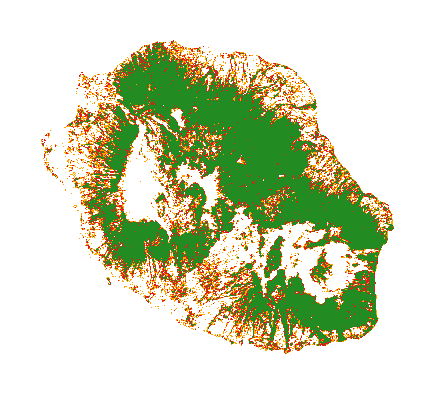

In [10]:
# Plot forest
fig_fcc123 = far.plot.fcc123(input_fcc_raster="data/forest/fcc123.tif",
                output_file="output/fcc123.png",
                figsize=(3,3),
                dpi=150)

### 1.2 Sampling the observations



In [11]:
# Sample points
dataset = far.sample(nsamp=10000, adapt=True, seed=1234, csize=10,
                     var_dir="data",
                     input_forest_raster="fcc23.tif",
                     output_file="output/sample.txt",
                     blk_rows=0)

Sample 2x 10000 pixels (deforested vs. forest)
Divide region in 110 blocks
Compute number of deforested and forest pixels per block
100%
Draw blocks at random
Draw pixels at random in blocks
100%
Compute center of pixel coordinates
Compute number of 10 x 10 km spatial cells
... 64 cells (8 x 8)
Identify cell number from XY coordinates
Make virtual raster with variables as raster bands
Extract raster values for selected pixels
100%
Export results to file output/sample.txt


In [12]:
# Remove NA from data-set (otherwise scale() and
# model_binomial_iCAR doesn't work)
dataset = dataset.dropna(axis=0)
# Set number of trials to one for far.model_binomial_iCAR()
dataset["trial"] = 1
# Print the first five rows
print(dataset.head(5))

   altitude  dist_defor  dist_edge  dist_river  dist_road  dist_town  fcc23  \
0     250.0      1071.0       30.0       600.0      808.0     1710.0    0.0   
1     381.0      3204.0       30.0       750.0        0.0      750.0    0.0   
2     483.0      3051.0       30.0      1383.0      335.0      750.0    0.0   
3      87.0       242.0       30.0         0.0      150.0     2148.0    0.0   
4     107.0       836.0       30.0      1050.0        0.0     2554.0    0.0   

    pa  slope          X          Y  cell  
0  0.0   12.0  6167205.0 -2363385.0   2.0  
1  0.0   12.0  6170595.0 -2362725.0   2.0  
2  0.0    9.0  6170055.0 -2363865.0   2.0  
3  0.0   17.0  6167625.0 -2362455.0   2.0  
4  0.0   23.0  6166635.0 -2362635.0   2.0  


In [17]:
# Sample size
ndefor = sum(dataset.fcc23 == 0)
nfor = sum(dataset.fcc23 == 1)
with open("output/sample_size.csv", "w") as f:
    f.write("var, n\n")
    f.write("ndefor, " + str(ndefor) + "\n")
    f.write("nfor, " + str(nfor) + "\n")

### 1.3 Correlation plots

In [31]:
# Model formulas
formula_1 = "fcc23 ~ dist_road + dist_town + dist_river + \
dist_defor + dist_edge + altitude + slope - 1"
# Standardized variables (mean=0, std=1)
formula_2 = "fcc23 ~ scale(dist_road) + scale(dist_town) + \
scale(dist_river) + scale(dist_defor) + scale(dist_edge) + \
scale(altitude) + scale(slope) - 1"
formulas = (formula_1, formula_2)

# Loop on formulas
for f in range(len(formulas)):
    # Output file
    of = "output/correlation_" + str(f) + ".pdf"
    # Data
    y, data = dmatrices(formulas[f], data=dataset,
                        return_type="dataframe")
    # Plots
    figs = far.plot.correlation(
        y=y, data=data,
        plots_per_page=3,
        figsize=(7, 8),
        dpi=100,
        output_file=of)
    plt.close("all")

## 2. Model

### 2.1 Model preparation

In [ ]:
# Spatial cells for spatial-autocorrelation
nneigh, adj = far.cellneigh(raster="data/fcc23.tif", csize=10, rank=1)

# List of variables
variables = ["C(pa)", "scale(altitude)", "scale(slope)",
             "scale(dist_defor)", "scale(dist_edge)", "scale(dist_road)",
             "scale(dist_town)", "scale(dist_river)"]
# Transform into numpy array
variables = np.array(variables)

# Starting values
beta_start = -99  # Simple GLM estimates
# Priors
priorVrho = -1  # -1="1/Gamma"

### 2.2 Variable selection

In [14]:
# Run model while there is non-significant variables
var_remove = True
while(np.any(var_remove)):
    # Formula
    right_part = " + ".join(variables) + " + cell"
    left_part = "I(1-fcc23) + trial ~ "
    formula = left_part + right_part
    # Model
    mod_binomial_iCAR = far.model_binomial_iCAR(
        # Observations
        suitability_formula=formula, data=dataset,
        # Spatial structure
        n_neighbors=nneigh, neighbors=adj,
        # Priors
        priorVrho=priorVrho,
        # Chains
        burnin=1000, mcmc=1000, thin=1,
        # Starting values
        beta_start=beta_start)
    # Ecological and statistical significance
    effects = mod_binomial_iCAR.betas[1:]
    # MCMC = mod_binomial_iCAR.mcmc
    # CI_low = np.percentile(MCMC, 2.5, axis=0)[1:-2]
    # CI_high = np.percentile(MCMC, 97.5, axis=0)[1:-2]
    positive_effects = (effects >= 0)
    # zero_in_CI = ((CI_low * CI_high) <= 0)
    # Keeping only significant variables
    var_remove = positive_effects
    # var_remove = np.logical_or(positive_effects, zero_in_CI)
    var_keep = np.logical_not(var_remove)
    variables = variables[var_keep]

Compute number of 10 x 10 km spatial cells
... 64 cells (8 x 8)
Identify adjacent cells and compute number of neighbors
Using estimates from classic logistic regression as starting values for betas
Using estimates from classic logistic regression as starting values for betas


### 2.3 Final model

In [15]:
# Model
mod_binomial_iCAR = far.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Chains
    burnin=1000, mcmc=1000, thin=1,
    # Starting values
    beta_start=-99)

Using estimates from classic logistic regression as starting values for betas


### 2.4 Model summary

In [30]:
# Predictions
pred_icar = mod_binomial_iCAR.theta_pred

# Summary
print(mod_binomial_iCAR)
# Write summary in file
with open("output/summary_hSDM.txt", "w") as f:
    f.write(str(mod_binomial_iCAR))

# Plot
figs = mod_binomial_iCAR.plot(
    output_file="output/mcmc.pdf",plots_per_page=3,
    figsize=(9, 6),
    dpi=100)
plt.close("all")

# Save model's main specifications with pickle
mod_icar_pickle = {
    "formula": mod_binomial_iCAR.suitability_formula,
    "rho": mod_binomial_iCAR.rho,
    "betas": mod_binomial_iCAR.betas,
    "Vrho": mod_binomial_iCAR.Vrho,
    "deviance": mod_binomial_iCAR.deviance}
with open("output/mod_icar.pickle", "wb") as pickle_file:
    pickle.dump(mod_icar_pickle, pickle_file)

Binomial logistic regression with iCAR process
  Model: I(1 - fcc23) + trial ~ 1 + C(pa) + scale(slope) + scale(dist_defor) + scale(dist_edge) + scale(dist_road) + cell
  Posteriors:
                        Mean        Std     CI_low    CI_high
        Intercept     -0.981      0.116      -1.22     -0.795
     C(pa)[T.1.0]     -0.439      0.121     -0.677     -0.187
     scale(slope)     -0.301     0.0295     -0.353     -0.238
scale(dist_defor)     -0.207     0.0277     -0.253     -0.151
 scale(dist_edge)       -3.8       0.21      -4.21       -3.4
 scale(dist_road)     -0.062      0.037     -0.129     0.0144
             Vrho       2.26      0.606       1.38       3.69
         Deviance   1.89e+04         44   1.89e+04   1.91e+04

Traces and posteriors will be plotted in output/mcmc.pdf


## 3. Model comparison and validation

### 3.1 Cross-validation

In [32]:
# Cross-validation for icar, glm and RF
CV_df_icar = far.cross_validation(
    dataset, formula, mod_type="icar", ratio=30, nrep=5,
    icar_args={"n_neighbors": nneigh, "neighbors": adj,
               "burnin": 1000, "mcmc": 1000, "thin": 1,
               "beta_start": mod_binomial_iCAR.betas})

CV_df_glm = far.cross_validation(dataset, formula, mod_type="glm", ratio=30, nrep=5)

CV_df_rf = far.cross_validation(dataset, formula, mod_type="rf", ratio=30, nrep=5,
                                rf_args={"n_estimators": 500, "n_jobs": 3})

# Save result to disk
CV_df_icar.to_csv("output/CV_icar.csv", header=True, index=False)
CV_df_glm.to_csv("output/CV_glm.csv", header=True, index=False)
CV_df_rf.to_csv("output/CV_rf.csv", header=True, index=False)

Repetition #: 1
Repetition #: 2
Repetition #: 3
Repetition #: 4
Repetition #: 5
Repetition #: 1
Repetition #: 2
Repetition #: 3
Repetition #: 4
Repetition #: 5
Repetition #: 1
Repetition #: 2
Repetition #: 3
Repetition #: 4
Repetition #: 5


In [35]:
print(CV_df_icar)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.8421  0.8437  0.8474  0.8487  0.8427  0.8449
1    OA  0.7585  0.7585  0.7649  0.7676  0.7605  0.7620
2    EA  0.5000  0.5002  0.5001  0.5000  0.5000  0.5001
3   FOM  0.6118  0.6054  0.6156  0.6252  0.6116  0.6139
4   Sen  0.7591  0.7542  0.7621  0.7694  0.7590  0.7608
5   Spe  0.7579  0.7627  0.7676  0.7657  0.7621  0.7632
6   TSS  0.5171  0.5169  0.5297  0.5351  0.5211  0.5240
7     K  0.5171  0.5169  0.5297  0.5351  0.5211  0.5240


In [36]:
print(CV_df_glm)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.8281  0.8302  0.8372  0.8301  0.8276  0.8306
1    OA  0.7585  0.7519  0.7622  0.7662  0.7552  0.7588
2    EA  0.5000  0.5002  0.5001  0.5000  0.5000  0.5001
3   FOM  0.6118  0.5967  0.6121  0.6234  0.6046  0.6097
4   Sen  0.7591  0.7475  0.7594  0.7680  0.7536  0.7575
5   Spe  0.7579  0.7561  0.7650  0.7644  0.7568  0.7600
6   TSS  0.5171  0.5036  0.5244  0.5324  0.5104  0.5176
7     K  0.5171  0.5036  0.5244  0.5324  0.5104  0.5176


In [37]:
print(CV_df_rf)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.8457  0.8403  0.8474  0.8488  0.8404  0.8445
1    OA  0.7625  0.7554  0.7644  0.7649  0.7560  0.7606
2    EA  0.5000  0.5002  0.5000  0.5000  0.5000  0.5001
3   FOM  0.6169  0.6001  0.6161  0.6195  0.6057  0.6117
4   Sen  0.7633  0.7502  0.7631  0.7658  0.7555  0.7596
5   Spe  0.7618  0.7604  0.7656  0.7639  0.7565  0.7616
6   TSS  0.5251  0.5105  0.5287  0.5298  0.5121  0.5212
7     K  0.5251  0.5105  0.5287  0.5298  0.5121  0.5212


### 3.2 Deviances

In [39]:
# Null model
formula_null = "I(1-fcc23) ~ 1"
y, x = dmatrices(formula_null, data=dataset, NA_action="drop")
Y = y[:, 0]
X_null = x[:, :]
mod_null = LogisticRegression(solver="lbfgs")
mod_null = mod_null.fit(X_null, Y)
pred_null = mod_null.predict_proba(X_null)

# Simple glm with no spatial random effects
formula_glm = formula
y, x = dmatrices(formula_glm, data=dataset, NA_action="drop")
Y = y[:, 0]
X_glm = x[:, :-1]  # We remove the last column (cells)
mod_glm = LogisticRegression(solver="lbfgs")
mod_glm = mod_glm.fit(X_glm, Y)
pred_glm = mod_glm.predict_proba(X_glm)

# Random forest model
formula_rf = formula
y, x = dmatrices(formula_rf, data=dataset, NA_action="drop")
Y = y[:, 0]
X_rf = x[:, :-1]  # We remove the last column (cells)
mod_rf = RandomForestClassifier(n_estimators=500, n_jobs=3)
mod_rf = mod_rf.fit(X_rf, Y)
pred_rf = mod_rf.predict_proba(X_rf)

# Deviances
deviance_null = 2*log_loss(Y, pred_null, normalize=False)
deviance_glm = 2*log_loss(Y, pred_glm, normalize=False)
deviance_rf = 2*log_loss(Y, pred_rf, normalize=False)
deviance_icar = mod_binomial_iCAR.deviance
deviance_full = 0
dev = [deviance_null, deviance_glm, deviance_rf, deviance_icar, deviance_full]

# Result table
mod_dev = pd.DataFrame({"model": ["null", "glm", "rf", "icar", "full"],
                        "deviance": dev})
perc = 100*(1-mod_dev.deviance/deviance_null)
mod_dev["perc"] = perc
mod_dev = mod_dev.round(0)
mod_dev.to_csv("output/model_deviance.csv", header=True, index=False)

In [40]:
print(mod_dev)

  model  deviance   perc
0  null   27713.0    0.0
1   glm   19772.0   29.0
2    rf    4750.0   83.0
3  icar   18947.0   32.0
4  full       0.0  100.0


In [41]:
# Save models' predictions
obs_pred = dataset
obs_pred["null"] = pred_null[:, 1]
obs_pred["glm"] = pred_glm[:, 1]
obs_pred["rf"] = pred_rf[:, 1]
obs_pred["icar"] = pred_icar
obs_pred.to_csv("output/obs_pred.csv", header=True, index=False)

## 4. Predict

### 4.1 Interpolate spatial random effects

In [42]:
# Spatial random effects
rho = mod_binomial_iCAR.rho

# Interpolate
far.interpolate_rho(rho=rho, input_raster="data/fcc23.tif",
                    output_file="output/rho.tif",
                    csize_orig=10, csize_new=1)

Write spatial random effect data to disk
Compute statistics
Build overview
Resampling spatial random effects to file output/rho.tif


### 4.2 Predict deforestation probability

In [43]:
# Update dist_edge and dist_defor at t3
os.rename("data/dist_edge.tif", "data/dist_edge.tif.bak")
os.rename("data/dist_defor.tif", "data/dist_defor.tif.bak")
copy2("data/forecast/dist_edge_forecast.tif", "data/dist_edge.tif")
copy2("data/forecast/dist_defor_forecast.tif", "data/dist_defor.tif")

# Compute predictions
far.predict_raster_binomial_iCAR(
    mod_binomial_iCAR, var_dir="data",
    input_cell_raster="output/rho.tif",
    input_forest_raster="data/forest/forest_t3.tif",
    output_file="output/prob.tif",
    blk_rows=10  # Reduced number of lines to avoid memory problems
)

# Reinitialize data
os.remove("data/dist_edge.tif")
os.remove("data/dist_defor.tif")
os.rename("data/dist_edge.tif.bak", "data/dist_edge.tif")
os.rename("data/dist_defor.tif.bak", "data/dist_defor.tif")

Make virtual raster with variables as raster bands
Divide region in 239 blocks
Create a raster file on disk for projections
Predict deforestation probability by block
100%
Compute statistics


## 5. Project future forest cover change

In [45]:
# Forest cover
fc = list()
dates = ["t1", "2005", "t2", "2015", "t3"]
ndates = len(dates)
for i in range(ndates):
    rast = "data/forest/forest_" + dates[i] + ".tif"
    val = far.countpix(input_raster=rast, value=1)
    fc.append(val["area"])  # area in ha
# Save results to disk
f = open("output/forest_cover.txt", "w")
for i in fc:
    f.write(str(i) + "\n")
f.close()
# Annual deforestation
T = 10.0
annual_defor = (fc[2] - fc[4]) / T

# Dates and time intervals
dates_fut = ["2030", "2035", "2040", "2050", "2055", "2060", "2070", "2080", "2085", "2090", "2100"]
ndates_fut = len(dates_fut)
ti = [10, 15, 20, 30, 35, 40, 50, 60, 65, 70, 80]


Divide region in 110 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 110 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 110 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 110 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 110 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha


In [47]:
# Loop on dates
for i in range(ndates_fut):
    # Amount of deforestation (ha)
    defor = np.rint(annual_defor * ti[i])
    # Compute future forest cover
    stats = far.deforest(
        input_raster="output/prob.tif",
        hectares=defor,
        output_file="output/fcc_" + dates_fut[i] + ".tif",
        blk_rows=128)
    # Save some stats if date = 2050
    if dates_fut[i] == "2050":
        # Save stats to disk with pickle
        pickle.dump(stats, open("output/stats.pickle", "wb"))
        # Plot histograms of probabilities
        fig_freq = far.plot.freq_prob(
            stats, output_file="output/freq_prob.png")
        plt.close(fig_freq)

Divide region in 19 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics
Divide region in 19 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics
Divide region in 19 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics
Divide region in 19 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statist

## 6. Carbon emissions

In [48]:
# Create dataframe
dpast = ["2020"]
dpast.extend(dates_fut)
C_df = pd.DataFrame({"date": dpast, "C": np.repeat(-99, ndates_fut + 1)},
                    columns=["date","C"])
# Loop on date
for i in range(ndates_fut):
    carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                           input_forest="output/fcc_" + dates_fut[i] + ".tif")
    C_df.loc[C_df["date"]==dates_fut[i], ["C"]] = carbon
# Past emissions 
carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                       input_forest="data/fcc23.tif")
C_df.loc[C_df["date"]==dpast[0], ["C"]] = carbon
# Save dataframe
C_df.to_csv("output/C_emissions.csv", header=True, index=False)

Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 19 blocks
Compute

## 7. Figures

In [49]:
# Forest at t3
fig_forest = far.plot.forest("data/forest/forest_t3.tif",
                             maxpixels=1e8,
                             borders="data/ctry_PROJ.shp",
                             output_file="output/forest_t3.png")
plt.close(fig_forest)

# Forest-cover change 123
fig_fcc = far.plot.fcc123("data/forest/fcc123.tif",
                          maxpixels=1e8,
                          borders="data/ctry_PROJ.shp",
                          output_file="output/fcc123.png")
plt.close(fig_fcc)

# Forest-cover change 12345
fig_fcc = far.plot.fcc12345("data/forest/fcc12345.tif",
                            maxpixels=1e8,
                            borders="data/ctry_PROJ.shp",
                            output_file="output/fcc12345.png")
plt.close(fig_fcc)

# Original spatial random effects
fig_rho_orig = far.plot.rho("output/rho_orig.tif",
                            borders="data/ctry_PROJ.shp",
                            output_file="output/rho_orig.png")
plt.close(fig_rho_orig)

# Interpolated spatial random effects
fig_rho = far.plot.rho("output/rho.tif",
                       borders="data/ctry_PROJ.shp",
                       output_file="output/rho.png")
plt.close(fig_rho)

# Spatial probability of deforestation
fig_prob = far.plot.prob("output/prob.tif",
                         maxpixels=1e8,
                         borders="data/ctry_PROJ.shp",
                         output_file="output/prob.png")
plt.close(fig_prob)

# Projected future forest-cover change
for i in range(ndates_fut):
    fig_fcc = far.plot.fcc("output/fcc_" + dates_fut[i] + ".tif",
                           maxpixels=1e8,
                           borders="data/ctry_PROJ.shp",
                           output_file="output/fcc_" + dates_fut[i] + ".png")
    plt.close(fig_fcc)

Build overview
